# Reconocedor de Gestos 
El objetivo de este reconocedor es utilizar redes neuronales, reconocimiento de patrones y procesamiento de imagenes para poder convertir en tiempo real una letra del lenguajes de señas americano a lenguaje escrito.

![Letras](https://www.researchgate.net/profile/Subarna_Tripathi/publication/281670522/figure/fig1/AS:324383521427456@1454350466334/ASL-fingerspelling-alphabets-and-numbers-13-We-follow-the-real-demonstrations-of.png)

### Carga el Ambiente de Anaconda
Primero, necesitas tener las bibliotecas de python necesarias instaladas en tu ambiente. En este caso, lo cargaremos en un ambiente de anaconda. El archivo `spec-file.txt` se encuentra en la carpeta env.

```
conda create -n [NOM_AMBIENTE] --file spec-file.txt # create new env with same packages
```

Después de correr este script, conda comenzara a instalar todas las bibliotecas necesarias para ejecutar el proyecto. 

### Imports
Primero hacemos el import de las bibliotecas que vamos a estar utilizando en el notebook.

- **numpy**: No ayuda a manejar Dataframes, una estructura similar a una tabla, y a utilizar matrices de forma más sencilla. 
- **cv2**: Nos sirve como una API que interactua con el feed de video y para hacer procesamiento de imagenes. 
- **matplotlib**: Hace graficas en el notebook.
- **sys**: Tiene herramientas básicas de uso de sistemas como cerrar ventanas, etc.
- **os**: nos permite usar funciones del sistema operativo como el manejo del sistema de archivos. 
- **time**: Agrega funciones para poder tomar el tiempo de ejecución de los programas y funciones. 
- **math**: Incluye funciones que permiten hacer calculos matematicos de forma sencilla.
- **Keras**: Una PI de alto nivel para crear redes neuronales y tensores. 

In [2]:
import numpy as np
import cv2
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
print('OpenCV Version: {}.{}.{}'.format(major_ver, minor_ver, subminor_ver))
import matplotlib.pyplot as plt
%matplotlib inline

import sys 
import os 
import time
import uuid 
import math 


import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D 

OpenCV Version: 3.4.1


Using TensorFlow backend.


### Definiciones 
Establecemos las definiciones de funciones y constantes del proyecto.

In [3]:
def bgr2rgb(image):
    '''
    Brief
    -----
    Cambia la codificación de una imagen de BGR (estandar
    en OpenCV) a RGB.

    Args
    -----
    image: np.array
    
    Return
    ------
    np.array en RGB
    
    '''
    return cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

In [4]:
def imprime_imagen(image, figsize=(8,8), recolour=False):
    """
    Brief
    ------
    Imprime una imagen hecha de matrices. Permite recuperar
    los colores de una imagen que paso a grises.
    
    Args
    ------
    image: np.array
    figsize = (int,int) 
    recolour: bool
    
    Return
    -------
    NULL
    
    """
    
    if recolour: image = bgr2rgb(image)
    plt.figure(figsize=figsize)
    if image.shape[-1] == 3:
        plt.imshow(image)
    elif image.shape[-1] == 1 or len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        raise Exception("Image has invalid shape.")

In [5]:
def mask_array(array, imask):
    """
    Brief
    -----
    Aplica una mascara a un arreglo de numpy. 
    
    Args
    -----
    array: np.array con el arreglo objetivo
    imask: np.array con la máscara
    
    Return
    ------
    output: np.array con la máscara aplicada. 
    
    """
    if array.shape[:2] != imask.shape:
        raise Exception("Shapes of input and imask are incompatible")
    output = np.zeros_like(array, dtype=np.uint8)
    for i, row in enumerate(imask):
        output[i, row] = array[i, row]
    return output

In [6]:
def salida_forzada():
    """
    Brief
    ------
    Esta función cierra todas las ventanas de openCV. Se utiliza porque hay casos en los que no cierra todo
    o que se traban las ventanas. 
    
    Args
    ----
    Null
    
    Return
    ------
    Null
    
    """
    cv2.destroyAllWindows()
    video.release()


In [6]:
# Generamos una constante con el PATH de las imagenes.
IMAGENES = os.path.join('imagenes/gestos')
MODELOS = os.path.join('modelos')
FOLDER_ACTUAL = os.getcwd()

### Leer camara
Creamos un objeto de OpenCV para caputurar el video de la camara de la computadora. 

In [6]:
video = cv2.VideoCapture(0)

while True:
    # Read a new frame
    success, frame = video.read()
    if not success:
        # Frame not successfully read from video capture
        break
        
    # Display result
    cv2.imshow("frame", frame)
    
    k = cv2.waitKey(1) & 0xff
    if k == 27: break # ESC pressed
        
cv2.destroyAllWindows()
video.release()

### Error al cerrar
Hay ocasiones en que OpenCV no cierra el video por lo que es necesario forzar el cierre de la captura de video. Para eso es necesario que se vuelva a ejecutar el cierre de la ventana y la liberacion del stream de video. 

In [7]:
salida_forzada()

# Preprocesamiento
Uno de los principales retos que tiene el reconocer los gestos de las manos es que se necesitarealizar un preprocesamiento del stream de video para poder enfocar el algoritmo en los target que nos son interesantes.

## Eliminación de fondo
Lo primero que tenemos que hacer para este sistema es eliminar el fondo del stream de video para poder tomar la sección de las imagen que nos interesa. PAra poder hacer esto fue necesario que hicieramos lo siguiente:

1. Cargamos la imagen completa (incluyendo el fondo).
2. Encontramos la diferencia entre los las imagenes.
3. Creamos un mapa de pixeles con el que podemos obtener los pixeles que nos interesan. 

_Fuente: [StackOverflow](https://stackoverflow.com/questions/31133903/opencv-remove-background)_

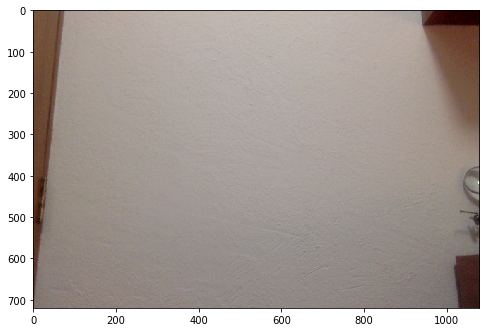

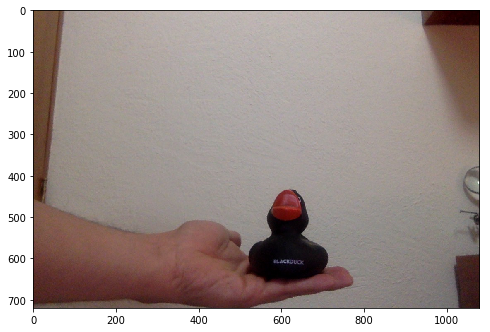

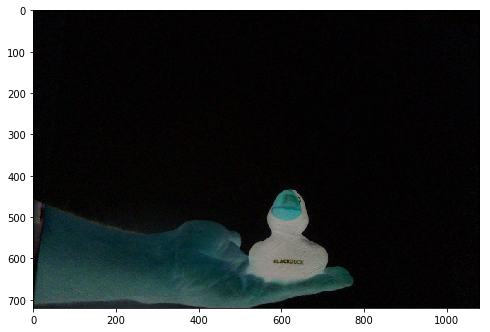

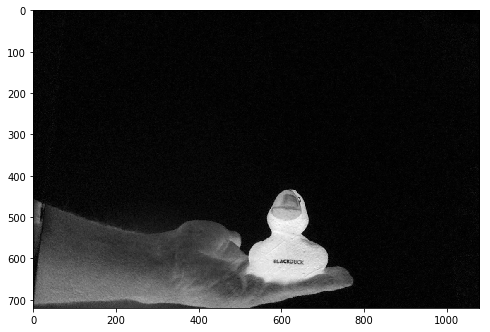

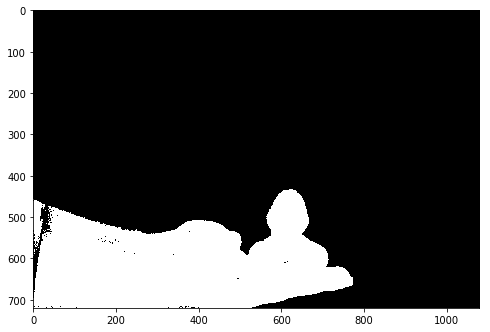

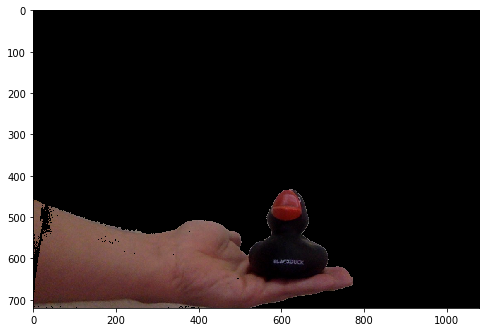

In [19]:
# Cargamos la imagen que sólo tiene el fondo y la que 
# tiene un objeto.
img_fondo = cv2.imread(os.path.join(IMAGENES, "fondo.jpg"))
img_objeto = cv2.imread(os.path.join(IMAGENES, "fondo-pato.jpg"))

# Calculamos la diferencia total entre el fondo y la 
# imagen con un pato. 

img_diff = cv2.absdiff(img_fondo, img_objeto)

# Creamos una mascara que contenga los pixeles que 
# nos interesan

img_mask = cv2.cvtColor(img_diff, cv2.COLOR_BGR2GRAY)

# A dicha mascara aplicamos un threshold binario para 
# resaltar el fondo del objeto de la imagen. 

th, mask_thresh = cv2.threshold(img_mask, 25, 255, cv2.THRESH_BINARY)
mask_indexes = mask_thresh > 0

# Creamos una matriz vacia con el tamaño de la foto la 
# cual va a contener la imagen con el objeto
objeto_aislado = np.zeros_like(img_objeto, dtype=np.uint8)
for i, row in enumerate(mask_indexes):
    objeto_aislado[i, row] = img_objeto[i, row]

imprime_imagen(img_fondo, recolour=True)
imprime_imagen(img_objeto, recolour=True)
imprime_imagen(img_diff, recolour=True)
imprime_imagen(img_mask)
imprime_imagen(mask_thresh)
imprime_imagen(objeto_aislado, recolour=True)



### ¡Importante!
Es importante considerar tener una buena camara, iluminación y posicionamiento del objeto porque de otra manera nuestro algoritmo cortará de más.
Para ajustar el corte también se puede mosficar el limite inferior del threshold para hacer más sensible el corte.

### Eliminar Fondo en video
Para eliminar el fondo en los videos podemos utilizar MOG2 o KNN para encontrar los pixeles que no se mueven en el stream de video y eliminarlos de manera automática.

*Fuente: [OpenCV](https://docs.opencv.org/3.1.0/db/d5c/tutorial_py_bg_subtraction.html)*


In [22]:
# Activamos la bandera de erosion
ERODE = True

# Elegimos cual de los dos algoritmos queremos utilizar
# para realizar el corte del fondo. 
fgbg = cv2.createBackgroundSubtractorMOG2()
# fgbg = cv2.createBackgroundSubtractorKNN()

video = cv2.VideoCapture(os.path.join(IMAGENES, 'tiburon.mp4'))

while True:
    time.sleep(0.025)
    
    timer = cv2.getTickCount()
    
    # Lee un nuevo frame
    success, frame = video.read()
    if not success:
        # Si hubo algun error entonces saldrá del algoritmo.
        break
    
    # Utiliza el algoritmo de eliminiación de fondo que 
    # elegimos y lo aplica como una máscara.
    fgmask = fgbg.apply(frame)
    
    # Utilizamos Erosion de una imagen para poder 
    # limpiar el ruido que pudo haerse generado. 
    if ERODE:
        fgmask = cv2.erode(fgmask, np.ones((3,3), dtype=np.uint8), iterations=1)
    
    # Calculamos la cantidad de Frames por segundo que 
    # pasan por el algoritmo
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Si lo deseamos, podemos mostrar la velocidad en FPS
    # del video que se esta viendo. 
    cv2.putText(fgmask, "FPS : " + str(int(fps)), (100, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)
 
    # Mostramos el resultado
    cv2.imshow("fgmask", fgmask)
    
    k = cv2.waitKey(1) & 0xff
    if k == 27: break # ESC pressed
        
cv2.destroyAllWindows()
video.release()

## Obtención de Contornos
Para obtener los contornos lo que hacemos en encontrar las esquinas de la imagen y lo conectamos con aquellos puntos que comparten el mismo color que la esquina. 

In [ ]:
#Activamos la bandera para generar el outline 
OUTLINE = True
LRG_ONLY = True

# window to hold the trackbar
img = np.zeros((300,512,3), np.uint8)
cv2.namedWindow('image')

# Creamos el tracker
cv2.createTrackbar('Thresh', 'image', 0, 255, lambda x: None)

earth_fname = os.path.join(IMAGES_FOLDER, 'earth.jpg')
earth_img = cv2.imread(earth_fname)

while True:
    thresh_min = cv2.getTrackbarPos('Thresh','image')
    
    contour_img = earth_img.copy()
    contour_img = cv2.cvtColor(contour_img, cv2.COLOR_BGR2GRAY)
    ret, contour_img_thresh = cv2.threshold(contour_img, thresh_min, 255, 0)
    im2, contours, hierarchy = cv2.findContours(contour_img_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if LRG_ONLY:
        cnts = [x for x in contours if cv2.contourArea(x) > 20000]
    else:
        cnts = sorted(contours, key = cv2.contourArea, reverse = True)[:3]

    if OUTLINE:
        # Dibujamos el outline
        contour_img_display = cv2.drawContours(earth_img.copy(), cnts, -1, (238, 255, 0), 2)
    else:
        # Dibujamos el contorno
        contour_img_display = cv2.drawContours(earth_img.copy(), cnts, -1, (238, 255, 0), -1)

    contour_img_display = cv2.cvtColor(contour_img_display, cv2.COLOR_BGR2RGB)
    
    cv2.imshow('image', contour_img_display)
    cv2.imshow('thresh', contour_img_thresh)
    
    k = cv2.waitKey(1) & 0xff
    if k == 27: break # ESC
        

cv2.destroyAllWindows()    


# Demo: Reconocimiento de Gestos

## Extraer a la persona
Lo primero que hacemos es extraer a la persona de la imagen que esta siendo grabada por la camara. Oprimiros r para elegir un escenario vacio.

In [ ]:
##################
# Inicialización #
##################

# Inicialiamos el proceso de captura de video utilizando OpenCV.
video = cv2.VideoCapture(0)

if not video.isOpened():
    # Si no puede abrir el stream de video entonces muestra un mensaje de error y 
    # cierra el programa.
    print("[Error] No se pudo iniciar el proceso de captura de video.")
    sys.exit()


# Leemos un frame del video
ok, frame = video.read()
if not ok:
    # Si no encuentra el frame es posible que el video no este funcionado apropiadamente. 
    # Cierra el programa en caso de que esto suceda. 
    print("[Error] No se pudo leer el frame.")
    sys.exit()
    
# Copiamos el primer frame del videopara tomarlo como fondo del sistema.
fondo = frame.copy()


# Creamos un Kernel de 3x3 para utilizarlo para erosionar la imagen.
kernel = np.ones((3,3),np.uint8)


# Iniciamos el loop de captura de video  
while True:

    # Obtenemos el nuevo frame de video.
    ok, frame = video.read()
    if not ok:
        # Es común que haya ocasiones en las que no encuentra el frame por lo que si no lo encuentra
        # Se salta ese frame.
        break
        
        
    # Comenzamos un Timer para obtener los FPS
    timer = cv2.getTickCount()

    #################
    # Procesamiento #
    #################
    
    # Encontramos las diferencias entre el fondo y el frame actual para despues convertirlo en
    # una máscara.
    diff = cv2.absdiff(fondo, frame)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

    # Aplicamos un threshold a la mascara resultante de la sección anterior y lo pasamos a escala de grises. 
    # Esto con el el objetivo de facilitar el recorte de la sección de interes en el frame. 
    th, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)

    # Dilatamos la imagen  para completar los epsacios vacios que se pudieron haber obtenido. 
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img_dilation = cv2.dilate(closing, kernel, iterations=2)
    # TODO v
    # Get mask indexes
    imask = img_dilation > 0
    # Obtenemos una mascara con la seccion con la región que nos interesa.
    foreground = mask_array(frame, imask)
    
        
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Display FPS on frame
    cv2.putText(frame, "FPS : " + str(int(fps)), (100, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    
    
    # Display result
    cv2.imshow("frame", frame)
    # Display diff
    cv2.imshow("diff", diff)
    # Display thresh
    cv2.imshow("thresh", thresh)
    # Display mask
    cv2.imshow("img_dilation", img_dilation)
    # Display foreground
    cv2.imshow("foreground", foreground)
    
    
    k = cv2.waitKey(1) & 0xff
    if k == 27: break # ESC pressed
    elif k == 114 or k == 112: 
        # r pressed
        fondo = frame.copy()
    elif k != 255: print(k)
        
cv2.destroyAllWindows()
video.release()

## Seguimiento de la Mano
Oprimimos 't' para comenzar con el tracking.

In [16]:
# Set up tracker.
def setup_tracker(ttype):
    tracker_types = ['BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'GOTURN']
    tracker_type = tracker_types[ttype]

    if int(minor_ver) < 3:
        tracker = cv2.Tracker_create(tracker_type)
    else:
        if tracker_type == 'BOOSTING':
            tracker = cv2.TrackerBoosting_create()
        if tracker_type == 'MIL':
            tracker = cv2.TrackerMIL_create()
        if tracker_type == 'KCF':
            tracker = cv2.TrackerKCF_create()
        if tracker_type == 'TLD':
            tracker = cv2.TrackerTLD_create()
        if tracker_type == 'MEDIANFLOW':
            tracker = cv2.TrackerMedianFlow_create()
        if tracker_type == 'GOTURN':
            tracker = cv2.TrackerGOTURN_create()
    
    return tracker

# Helper function for applying a mask to an array
def mask_array(array, imask):
    if array.shape[:2] != imask.shape:
        raise Exception("Shapes of input and imask are incompatible")
    output = np.zeros_like(array, dtype=np.uint8)
    for i, row in enumerate(imask):
        output[i, row] = array[i, row]
    return output


# Begin capturing video
video = cv2.VideoCapture(0)
if not video.isOpened():
    print("Could not open video")
    sys.exit()


# Read first frame
ok, frame = video.read()
if not ok:
    print("Cannot read video")
    sys.exit()
# Use the first frame as an initial background frame
bg = frame.copy()


# Kernel for erosion and dilation of masks
kernel = np.ones((3,3),np.uint8)


# Tracking
# Bounding box -> (TopRightX, TopRightY, Width, Height)
bbox_initial = (60, 60, 170, 170)
bbox = bbox_initial
# Tracking status, -1 for not tracking, 0 for unsuccessful tracking, 1 for successful tracking
tracking = -1


# Text display positions
positions = {
    'fps': (15, 20)
}


# Capture, process, display loop    
while True:
    # Read a new frame
    ok, frame = video.read()
    display = frame.copy()
    if not ok:
        break
        
        
    # Start timer
    timer = cv2.getTickCount()

    
    # Processing
    # First find the absolute difference between the two images
    diff = cv2.absdiff(bg, frame)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    # Threshold the mask
    th, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
    # Opening, closing and dilation
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img_dilation = cv2.dilate(closing, kernel, iterations=2)
    # Get mask indexes
    imask = img_dilation > 0
    # Get foreground from mask
    foreground = mask_array(frame, imask)
    foreground_display = foreground.copy()
    
    
    # If tracking is active, update the tracker
    if tracking != -1:
        tracking, bbox = tracker.update(foreground)
        tracking = int(tracking)
        
        
    # Use numpy array indexing to crop the hand
    hand_crop = frame[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]
    
        
    # Draw bounding box
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(foreground_display, p1, p2, (255, 0, 0), 2, 1)
    cv2.rectangle(display, p1, p2, (255, 0, 0), 2, 1)
    
        
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Display FPS on frame
    cv2.putText(foreground_display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    cv2.putText(display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    
    
    # Display result
    cv2.imshow("display", display)
    # Display diff
    cv2.imshow("diff", diff)
    # Display thresh
    cv2.imshow("thresh", thresh)
    # Display mask
    cv2.imshow("img_dilation", img_dilation)
    try:
        # Display hand_crop
        cv2.imshow("hand_crop", hand_crop)
    except:
        pass
    # Display foreground_display
    cv2.imshow("foreground_display", foreground_display)
    
    
    k = cv2.waitKey(1) & 0xff
    
    if k == 27: break # ESC pressed
    elif k == 114 or k == 112: 
        # r pressed
        bg = frame.copy()
        bbox = bbox_initial
        tracking = -1
    elif k == 116:
        # t pressed
        # Initialize tracker with first frame and bounding box
        tracker = setup_tracker(2)
        tracking = tracker.init(frame, bbox)
    elif k == 115:
        # s pressed
        fname = os.path.join("data", CURR_POS, "{}_{}.jpg".format(CURR_POS, get_unique_name(os.path.join("data", CURR_POS))))
        cv2.imwrite(fname, hand_crop)
    elif k != 255: print(k)
        
cv2.destroyAllWindows()
video.release()

## Recolección de Datos

classes = {
    0: 'fist',
    1: 'five',
    2: 'point',
    3: 'swing'
}

CURR_POSE = 'fist'

In [50]:
DATA = os.path.join('imagenes/conjunto_entren',CURR_POSE)


def setup_tracker(ttype):
    tracker_types = ['BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'GOTURN']
    tracker_type = tracker_types[ttype]

    if int(minor_ver) < 3:
        tracker = cv2.Tracker_create(tracker_type)
    else:
        if tracker_type == 'BOOSTING':
            tracker = cv2.TrackerBoosting_create()
        if tracker_type == 'MIL':
            tracker = cv2.TrackerMIL_create()
        if tracker_type == 'KCF':
            tracker = cv2.TrackerKCF_create()
        if tracker_type == 'TLD':
            tracker = cv2.TrackerTLD_create()
        if tracker_type == 'MEDIANFLOW':
            tracker = cv2.TrackerMedianFlow_create()
        if tracker_type == 'GOTURN':
            tracker = cv2.TrackerGOTURN_create()
    
    return tracker


def mask_array(array, imask):
    if array.shape[:2] != imask.shape:
        raise Exception("Shapes of input and imask are incompatible")
    output = np.zeros_like(array, dtype=np.uint8)
    for i, row in enumerate(imask):
        output[i, row] = array[i, row]
    return output



video = cv2.VideoCapture(0)
if not video.isOpened():
    print("Could not open video")
    sys.exit()



ok, frame = video.read()
if not ok:
    print("Cannot read video")
    sys.exit()

bg = frame.copy()



kernel = np.ones((3,3),np.uint8)


bbox_initial = (60, 60, 170, 170)
bbox = bbox_initial

tracking = -1



positions = {
    'hand_pose': (15, 40),
    'fps': (15, 20)
}



img_count = 0


while True:
    ok, frame = video.read()
    display = frame.copy()
    if not ok:
        break
        
        
    timer = cv2.getTickCount()

    
    diff = cv2.absdiff(bg, frame)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

    th, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)

    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img_dilation = cv2.dilate(closing, kernel, iterations=2)

    imask = img_dilation > 0

    foreground = mask_array(frame, imask)
    foreground_display = foreground.copy()
    
    

    if tracking != -1:
        tracking, bbox = tracker.update(foreground)
        tracking = int(tracking)
        
        

    hand_crop = img_dilation[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]
    
        

    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(foreground_display, p1, p2, (255, 0, 0), 2, 1)
    cv2.rectangle(display, p1, p2, (255, 0, 0), 2, 1)
    
        

    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    cv2.putText(foreground_display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    cv2.putText(display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    
    
    # Display result
    cv2.imshow("display", display)
    # Display diff
    cv2.imshow("diff", diff)
    # Display thresh
    cv2.imshow("thresh", thresh)
    # Display mask
    cv2.imshow("img_dilation", img_dilation)
    try:
        # Display hand_crop
        cv2.imshow("hand_crop", hand_crop)
    except:
        pass
    # Display foreground_display
    cv2.imshow("foreground_display", foreground_display)
    
    
    k = cv2.waitKey(1) & 0xff
    
    if k == 27: break # ESC pressed
    elif k == 114 or k == 112: 
        # r pressed
        bg = frame.copy()
        bbox = bbox_initial
        tracking = -1
    elif k == 116:
        # t pressed
        # Inicializa el tracker con el bound box 
        tracker = setup_tracker(2)
        tracking = tracker.init(frame, bbox)
    elif k == 115:
        # s pressed
        img_count += 1
        fname = os.path.join('imagenes/conjunto_validacion', CURR_POSE, "{}_{}.jpg".format(CURR_POSE, img_count))
        #fname = DATA
        cv2.imwrite(fname, hand_crop)
        print("Guardado como: {0}".format(fname))
    elif k != 255: print(k)
        
cv2.destroyAllWindows()
video.release()

Guardado como: imagenes/conjunto_validacion\fist\fist_1.jpg
Guardado como: imagenes/conjunto_validacion\fist\fist_2.jpg
Guardado como: imagenes/conjunto_validacion\fist\fist_3.jpg
Guardado como: imagenes/conjunto_validacion\fist\fist_4.jpg
Guardado como: imagenes/conjunto_validacion\fist\fist_5.jpg
Guardado como: imagenes/conjunto_validacion\fist\fist_6.jpg
Guardado como: imagenes/conjunto_validacion\fist\fist_7.jpg
Guardado como: imagenes/conjunto_validacion\fist\fist_8.jpg
Guardado como: imagenes/conjunto_validacion\fist\fist_9.jpg
Guardado como: imagenes/conjunto_validacion\fist\fist_10.jpg
Guardado como: imagenes/conjunto_validacion\fist\fist_11.jpg
Guardado como: imagenes/conjunto_validacion\fist\fist_12.jpg
Guardado como: imagenes/conjunto_validacion\fist\fist_13.jpg
Guardado como: imagenes/conjunto_validacion\fist\fist_14.jpg
Guardado como: imagenes/conjunto_validacion\fist\fist_15.jpg
Guardado como: imagenes/conjunto_validacion\fist\fist_16.jpg
Guardado como: imagenes/conjunto_

In [ ]:
cv2.destroyAllWindows()
video.release()

## Construimos la Red Neuronal
Comstruimos una red neuronal convolucional de 3 capas Convolucionales seguidas de una funciona de activacion `relu` y aplicando max pooling.

### Carcateristicas de la Red
´model.add(Conv2D(32, (3, 3), input_shape=(54, 54, 1)))´: Crea una capa de Convolucion 2D que contiene 32 filtros, establecemos que el tamaño del kernel sea de de una longitud (3,3). Establecemos que queremos secuencias de 54 vectores con un tamaño de (54,1).

In [51]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(54, 54, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Preparamos el dataset

In [52]:
batch_size = 16

training_datagen = ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=10)

training_generator = training_datagen.flow_from_directory(
    'imagenes/conjunto_entren',
    target_size=(54, 54),
    batch_size=batch_size,
    color_mode='grayscale'
)

validation_generator = validation_datagen.flow_from_directory(
    'imagenes/conjunto_validacion',
    target_size=(54, 54),
    batch_size=batch_size,
    color_mode='grayscale'
)

Found 2735 images belonging to 4 classes.
Found 372 images belonging to 4 classes.


In [5]:

"""img = load_img('imagenes/conjunto_entren/swing/swing_1.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

i = 0
for batch in training_datagen.flow(x, batch_size=1,
                          save_to_dir='imagenes/preview', save_prefix='swing', save_format='jpeg'):
    i += 1
    if i > 20:
        break"""

In [53]:
MODEL_PATH = os.path.join('modelos')
MODEL_FILE = os.path.join(MODEL_PATH, 'modelo-manos.hdf5') 
MODEL_HISTORY = os.path.join(MODEL_PATH, 'historial-modelo.txt')
"""
model.fit_generator(
    generator=training_generator,
    steps_per_epoch=2000 // batch_size,
    epochs=45,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=200 // batch_size,
    workers=8,
)"""

Epoch 1/45
125/125 [==============================] - 5s 36ms/step - loss: 4.2397 - acc: 0.5668 - val_loss: 0.2126 - val_acc: 0.9479
Epoch 2/45
125/125 [==============================] - 4s 33ms/step - loss: 0.4451 - acc: 0.8425 - val_loss: 0.3591 - val_acc: 0.8281
Epoch 3/45
125/125 [==============================] - 4s 32ms/step - loss: 0.3037 - acc: 0.8810 - val_loss: 0.2782 - val_acc: 0.8802
Epoch 4/45
125/125 [==============================] - 4s 32ms/step - loss: 0.2286 - acc: 0.9175 - val_loss: 0.1534 - val_acc: 0.9375
Epoch 5/45
125/125 [==============================] - 4s 33ms/step - loss: 0.1914 - acc: 0.9305 - val_loss: 0.2577 - val_acc: 0.8594
Epoch 6/45
125/125 [==============================] - 4s 32ms/step - loss: 0.1367 - acc: 0.9450 - val_loss: 0.2150 - val_acc: 0.8802
Epoch 7/45
125/125 [==============================] - 4s 32ms/step - loss: 0.1697 - acc: 0.9420 - val_loss: 0.0249 - val_acc: 0.9948
Epoch 8/45
125/125 [==============================] - 4s 32ms/step - 

In [46]:
import re
with open(MODEL_HISTORY) as history_file:
    history = history_file.read()

data = {}

data['acc'] = re.findall(' acc: ([0-9]+\.[0-9]+)', history)
data['loss'] = re.findall(' loss: ([0-9]+\.[0-9]+)', history)
data['val_acc'] = re.findall(' val_acc: ([0-9]+\.[0-9]+)', history)
data['val_loss'] = re.findall(' val_loss: ([0-9]+\.[0-9]+)', history)

for key, values in data.items():
    for i, val in enumerate(values):
        values[i] = float(val)

plt.figure()
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.plot(data['loss'])


plt.figure()
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.plot(data['acc'])


plt.figure()
plt.title("Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.plot(data['val_loss'])


plt.figure()
plt.title("Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.plot(data['val_acc'])

FileNotFoundError: [Errno 2] No such file or directory: 'modelos\\historial-modelo.txt'

In [54]:
model.save("hand_model_gray.hdf5")

## Probar el modelo

In [3]:
hand_model = load_model('hand_model_gray.hdf5', compile=False)

In [4]:
classes = {
    0: 'fist',
    1: 'five',
    2: 'point',
    3: 'swing'
}

# Pnemos el tracker en su lugar
def setup_tracker(ttype):
    tracker_types = ['BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'GOTURN']
    tracker_type = tracker_types[ttype]

    if int(minor_ver) < 3:
        tracker = cv2.Tracker_create(tracker_type)
    else:
        if tracker_type == 'BOOSTING':
            tracker = cv2.TrackerBoosting_create()
        if tracker_type == 'MIL':
            tracker = cv2.TrackerMIL_create()
        if tracker_type == 'KCF':
            tracker = cv2.TrackerKCF_create()
        if tracker_type == 'TLD':
            tracker = cv2.TrackerTLD_create()
        if tracker_type == 'MEDIANFLOW':
            tracker = cv2.TrackerMedianFlow_create()
        if tracker_type == 'GOTURN':
            tracker = cv2.TrackerGOTURN_create()
    
    return tracker

# Aplicamos la mascara con la funcion axiliar creada al inicio del documento
def mask_array(array, imask):
    if array.shape[:2] != imask.shape:
        raise Exception("Shapes of input and imask are incompatible")
    output = np.zeros_like(array, dtype=np.uint8)
    for i, row in enumerate(imask):
        output[i, row] = array[i, row]
    return output


# Iniciamos el stream de video
video = cv2.VideoCapture(0)
if not video.isOpened():
    print("Could not open video")
    sys.exit()


#Lee el frame
ok, frame = video.read()
if not ok:
    print("Cannot read video")
    sys.exit()
# Use the first frame as an initial background frame
bg = frame.copy()


# Erosionamos la imagen 
kernel = np.ones((3,3),np.uint8)


# Display positions (pixel coordinates)
positions = {
    'hand_pose': (15, 40), # hand pose text
    'fps': (15, 20), # fps counter
    'null_pos': (200, 200) # used as null point for mouse control
}


# Inicamos el tracking en el bound box
# Bounding box -> (TopRightX, TopRightY, Width, Height)
bbox_initial = (116, 116, 170, 170) # Starting position for bounding box
bbox = bbox_initial
# Tracking status, -1 for not tracking, 0 for unsuccessful tracking, 1 for successful tracking
tracking = -1


# Capture, process, display loop    
while True:
    # Read a new frame
    ok, frame = video.read()
    display = frame.copy()
    data_display = np.zeros_like(display, dtype=np.uint8) # Black screen to display data
    if not ok:
        break
        
        
    # Start timer
    timer = cv2.getTickCount()

    
    # Procesamiento
    # Diferencia absoluta de la imagen con fondo y la caputrada 
    diff = cv2.absdiff(bg, frame)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    # Mascara de threshold
    th, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
    # Opening, closing and dilation
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img_dilation = cv2.dilate(closing, kernel, iterations=2)
    # Condeguimos los indices de la mascara
    imask = img_dilation > 0
    # Obtenemos el objeto de interes
    foreground = mask_array(frame, imask)
    foreground_display = foreground.copy()
    
    
    # Actualizamos el tracker
    if tracking != -1:
        tracking, bbox = tracker.update(foreground)
        tracking = int(tracking)
        
        
    # Cortamos la imagen objetivo con los valores del bound box
    hand_crop = img_dilation[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]
    try:
        # Resize cropped hand and make prediction on gesture
        hand_crop_resized = np.expand_dims(cv2.resize(hand_crop, (54, 54)), axis=0).reshape((1, 54, 54, 1))
        prediction = hand_model.predict(hand_crop_resized)
        predi = prediction[0].argmax() #Obtenemos el indice con el mayor indice
        gesture = classes[predi]
        
        for i, pred in enumerate(prediction[0]):
            # Dibujamos las barras de confiabilidad
            barx = positions['hand_pose'][0]
            bary = 60 + i*60
            bar_height = 20
            bar_length = int(400 * pred) + barx # calculate length of confidence bar
            
            # Hacemos el de mayor confiabilidad en verde
            if i == predi:
                colour = (0, 255, 0)
            else:
                colour = (0, 0, 255)
            
            cv2.putText(data_display, "{}: {}".format(classes[i], pred), (positions['hand_pose'][0], 30 + i*60), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2)
            cv2.rectangle(data_display, (barx, bary), (bar_length, bary - bar_height), colour, -1, 1)
        
        cv2.putText(display, "hand pose: {}".format(gesture), positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        cv2.putText(foreground_display, "hand pose: {}".format(gesture), positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    except Exception as ex:
        cv2.putText(display, "hand pose: error", positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        cv2.putText(foreground_display, "hand pose: error", positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    
        
    # Dibuja Bound Box
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(foreground_display, p1, p2, (255, 0, 0), 2, 1)
    cv2.rectangle(display, p1, p2, (255, 0, 0), 2, 1)
    
    
    # Mueve el mouse
    hand_pos = ((p1[0] + p2[0])//2, (p1[1] + p2[1])//2)
    mouse_change = ((p1[0] + p2[0])//2 - positions['null_pos'][0], positions['null_pos'][0] - (p1[1] + p2[1])//2)
    # Dibuja los puntos entre el mouse y el centro
    cv2.circle(display, positions['null_pos'], 5, (0,0,255), -1)
    cv2.circle(display, hand_pos, 5, (0,255,0), -1)
    cv2.line(display,positions['null_pos'],hand_pos,(255,0,0),5)
    
        
    # Calculo de FPS
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Display FPS on frame
    cv2.putText(foreground_display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    cv2.putText(display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    
    
    # Imprime el resultado
    cv2.imshow("display", display)
    # Imprime el resultado
    cv2.imshow("data", data_display)
    # Imprime el diff resultante
    cv2.imshow("diff", diff)
    # Imprime el thresh resultante
    cv2.imshow("thresh", thresh)
    # Imprime la mascara resultante
    cv2.imshow("img_dilation", img_dilation)
    try:
        # Ventana de la mano recortada
        cv2.imshow("hand_crop", hand_crop)
    except:
        pass
    # Muestra el objeto de interes
    cv2.imshow("foreground_display", foreground_display)
    
    
    k = cv2.waitKey(1) & 0xff
    
    if k == 27: break # ESC pressed
    elif k == 114 or k == 108: 
        # r pressed
        bg = frame.copy()
        bbox = bbox_initial
        tracking = -1
    elif k == 116:
        # t pressed
        # Initialize tracker with first frame and bounding box
        tracker = setup_tracker(2)
        tracking = tracker.init(frame, bbox)
    elif k == 115:
        # s pressed
        fname = os.path.join("data", CURR_POS, "{}_{}.jpg".format(CURR_POS, get_unique_name(os.path.join("data", CURR_POS))))
        cv2.imwrite(fname, hand_crop)
    elif k != 255: print(k)
        
cv2.destroyAllWindows()
video.release()

## Referencias

- Kang, B., Tripathi, S., & Nguyen, T. Q. (2015). Real-time sign language fingerspelling recognition using convolutional neural networks from depth map [Abstract]. 2015 3rd IAPR Asian Conference on Pattern Recognition (ACPR). doi:10.1109/acpr.2015.7486481

In [7]:
salida_forzada()